In [479]:
import numpy as np
from matplotlib import pyplot as plt

from qutrit_rpe import *

%load_ext autoreload 
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [480]:
xvec = random_error_vector(0.0, 0.01)
qids = ['Q0', 'Q1']
depol_rates = [0.00, 0.0] # 1 and 2 qubit depolarizing rates

In [481]:
parse_error_vector(xvec, qids)

{'single_qutrit': {'Q0': {'X01': 0.0,
   'phase01': 0.0,
   'X12': 0.0,
   'phase12': 0.0},
  'Q1': {'X01': 0.0, 'phase01': 0.0, 'X12': 0.0, 'phase12': 0.0}},
 'two_qutrit': {'phi1': 0.023248989963837008,
  'phi2': 0.07670678977433654,
  'phi3': 0.09687870659416306,
  'phi4': 0.12404664202494826,
  'phi5': 0.09092878594804177,
  'phi6': 0.012313249129309553,
  'phi7': -0.013858857931640552,
  'phi8': 0.13137522859920092}}

In [482]:
target_model = make_two_qutrit_model(np.zeros(16), single_qutrit_depol=0.0, two_qutrit_depol=0.0, qids=qids)
noise_model = make_two_qutrit_model(xvec, single_qutrit_depol=depol_rates[0], two_qutrit_depol=depol_rates[1], qids=qids)

In [483]:
depths = [2**i for i in range(10)]
edesign0 = RPEDesign1QT(depths, qids[0], qids)
edesign1 = RPEDesign1QT(depths, qids[1], qids)

In [484]:
ds0_model = pygsti.data.simulate_data(noise_model, edesign0.circ_list, num_samples=1000)
ds0_target = pygsti.data.simulate_data(target_model, edesign0.circ_list, num_samples=1000)
ds1_target = pygsti.data.simulate_data(target_model, edesign1.circ_list, num_samples=1000)
ds1_model = pygsti.data.simulate_data(noise_model, edesign1.circ_list, num_samples=1000)

In [485]:
germ_quadrature_labels_Q1 = {
    'X01 overrot': {
        '+': ['00'],
        '-': ['01']
    },
    'Phase01' : {
        '+' : ['00'], 
        '-' : ['02']
    },
    'X12 overrot': {
        '+': ['01'],
        '-': ['02']
    },
    'Phase12' : {
        '+' : ['00'], 
        '-' : ['01']
    }}

germ_quadrature_labels_Q0 = {
    'X01 overrot': {
        '+': ['00'],
        '-': ['10']
    },
    'Phase01' : {
        '+' : ['00'], 
        '-' : ['20']
    },
    'X12 overrot': {
        '+': ['10'],
        '-': ['20']
    },
    'Phase12' : {
        '+' : ['00'], 
        '-' : ['10']
    }}

In [486]:
estimator0 = RPEEstimator1QT(ds0_model, edesign0, germ_quadrature_labels_Q0)
estimator1 = RPEEstimator1QT(ds1_model, edesign1, germ_quadrature_labels_Q1)

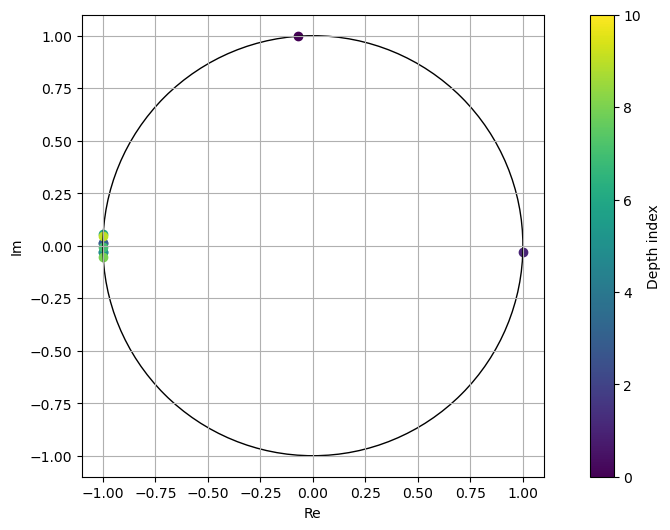

In [487]:
signals = estimator0.signals
estimator0.plot_signal_on_circle(signals['X01 overrot'])

In [488]:
2*np.pi

6.283185307179586

In [489]:
print(estimator0.trig_last_good_gens)
print(estimator1.trig_last_good_gens)

{'Phase01': 9, 'Phase12': 9, 'X01 overrot': 9, 'X12 overrot': 9}
{'Phase01': 9, 'Phase12': 9, 'X01 overrot': 9, 'X12 overrot': 9}


In [490]:
print(estimator0.param_estimates)
print(estimator1.param_estimates)

{'Phase01': -1.6923270643805683e-05, 'Phase12': 2.8627368665971414e-05, 'X01 overrot': 9.367809937010918e-05, 'X12 overrot': 2.343637509749641e-05}
{'Phase01': 2.0826226588166463e-05, 'Phase12': -1.432060657376629e-05, 'X01 overrot': 9.757499164475547e-05, 'X12 overrot': 8.97804605415331e-05}


In [491]:
parse_error_vector(xvec)

{'single_qutrit': {'Q0': {'X01': 0.0,
   'phase01': 0.0,
   'X12': 0.0,
   'phase12': 0.0},
  'Q1': {'X01': 0.0, 'phase01': 0.0, 'X12': 0.0, 'phase12': 0.0}},
 'two_qutrit': {'phi1': 0.023248989963837008,
  'phi2': 0.07670678977433654,
  'phi3': 0.09687870659416306,
  'phi4': 0.12404664202494826,
  'phi5': 0.09092878594804177,
  'phi6': 0.012313249129309553,
  'phi7': -0.013858857931640552,
  'phi8': 0.13137522859920092}}

# two qubit experiment

In [627]:
depths = [2**i for i in range(6)]
edesign2 = RPEDesign2QT(depths, qids)

In [628]:
ds2_model = pygsti.data.simulate_data(noise_model, edesign2.circ_list, num_samples=1000)
ds2_target = pygsti.data.simulate_data(target_model, edesign2.circ_list, num_samples=1000)

In [634]:
# germ_quadrature_labels_2QT = {
#     'theta1': {
#         '+': ['00'],
#         '-': ['01']
#     },
#     'theta2': {
#         '+': ['01'],
#         '-': ['02']
#     },
#     'theta3': {
#         '+': ['10'],
#         '-': ['11']
#     },
#     'theta4': {
#         '+': ['11'],
#         '-': ['12']
#     },
#     'theta5': {
#         '+': ['20'],
#         '-': ['21']
#     },
#     'theta6': {
#         '+': ['21'],
#         '-': ['22']
#     },
#     'theta7': {
#         '+': ['01'],
#         '-': ['11']
#     },
#     'theta8': {
#         '+': ['11'],
#         '-': ['21']
#     },
# }

germ_quadrature_labels_2QT = {
    'theta1': {
        '+': ['00'],
        '-': ['01']
    },
    'theta2': {
        '+': ['00'],
        '-': ['02']
    },
    'theta3': {
        '+': ['00'],
        '-': ['01']
    },
    'theta4': {
        '+': ['00'],
        '-': ['02']
    },
    'theta5': {
        '+': ['00'],
        '-': ['01']
    },
    'theta6': {
        '+': ['00'],
        '-': ['02']
    },
    'theta7': {
        '+': ['00'],
        '-': ['10']
    },
    'theta8': {
        '+': ['00'],
        '-': ['20']
    },
}

In [639]:
def add_phases(phase1, phase2):
  return (phase1 + phase2) % (2 * np.pi)

def subtract_phases(phase1, phase2):
  return (phase1 - phase2) % (2 * np.pi)

In [640]:
edesign2.circuit_dict.keys()

dict_keys(['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8'])

In [641]:
estimator2 = RPEEstimator2QT(ds2_model, edesign2, germ_quadrature_labels_2QT)

In [642]:
estimator2.trig_last_good_gens

{'theta1': 5,
 'theta2': 5,
 'theta3': 5,
 'theta4': 5,
 'theta5': 5,
 'theta6': 5,
 'theta7': 5,
 'theta8': 5}

[6.25911835 6.228896   4.1616483  4.21976695 0.02687019 6.13780341
 4.08594018 2.23334267]


<BarContainer object of 8 artists>

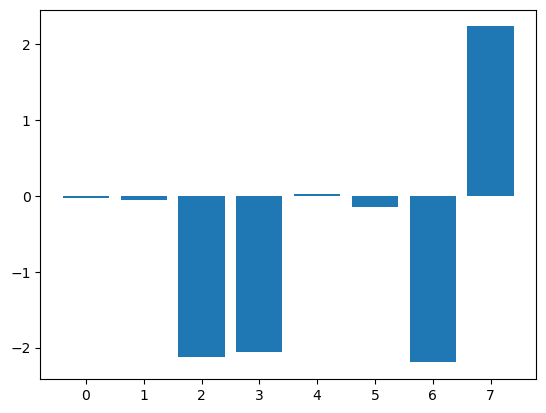

In [643]:
raw = estimator2.raw_estimates
print(raw)
plt.bar(range(len(raw)), rectify_angle(raw))

<BarContainer object of 8 artists>

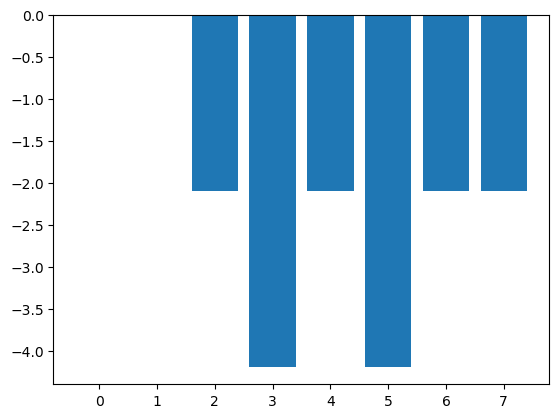

In [644]:
plt.bar(range(8), np.array([
            [1, 0, 0, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, -1, 1, 0, 0, 0, 0],
            [0, 0, -1, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, -1, 1, 0],
            [0, 0, 0, 0, 0, -1, 0, 1],
            [-1, 0, 0, 1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0, 0, 1, 0]
        ])@target_phis)

[-0.02406696 -0.05428931 -0.09977508 -2.22131209 -2.16319343  2.18240552
  2.20927571  2.03702363]


<BarContainer object of 8 artists>

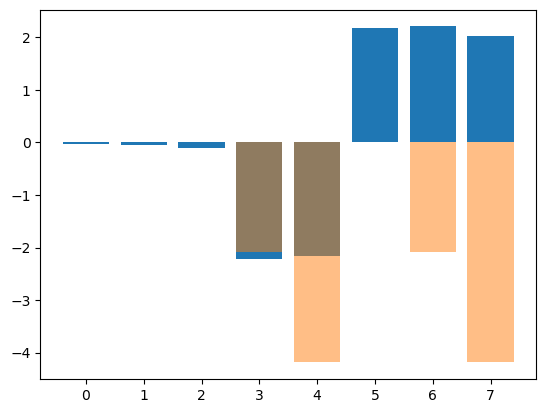

In [645]:
angles = rectify_angle(estimator2.param_estimates)
print(angles)
plt.bar(range(len(angles)), angles)
plt.bar(range(len(angles)), target_phis, alpha=0.5)

In [646]:
target_phis

array([ 0.       ,  0.       ,  0.       , -2.0943951, -4.1887902,
        0.       , -2.0943951, -4.1887902])

In [647]:
rectify_angle(angles)

array([-0.02406696, -0.05428931, -0.09977508, -2.22131209, -2.16319343,
        2.18240552,  2.20927571,  2.03702363])

In [648]:
rectify_angle(angles - target_phis)

array([-0.02406696, -0.05428931, -0.09977508, -0.12691699,  2.02559677,
        2.18240552, -1.9795145 , -0.05737148])

In [649]:
parse_error_vector(xvec)['two_qutrit']

{'phi1': 0.023248989963837008,
 'phi2': 0.07670678977433654,
 'phi3': 0.09687870659416306,
 'phi4': 0.12404664202494826,
 'phi5': 0.09092878594804177,
 'phi6': 0.012313249129309553,
 'phi7': -0.013858857931640552,
 'phi8': 0.13137522859920092}

In [596]:
target_phis

array([ 0.       ,  0.       ,  0.       , -2.0943951, -4.1887902,
        0.       , -2.0943951, -4.1887902])

In [597]:
np.linalg.inv(np.array([
            [1, 0, 0, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, -1, 1, 0, 0, 0, 0],
            [0, 0, -1, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, -1, 1, 0],
            [0, 0, 0, 0, 0, -1, 0, 1],
            [-1, 0, 0, 1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0, 0, 1, 0]
        ]))

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -0., -1., -0., -0., -0.,  1., -0.],
       [ 1., -0., -0., -0., -0., -0.,  1., -0.],
       [ 1.,  0., -1.,  1.,  0.,  0.,  1.,  0.],
       [ 1., -0., -0., -0., -1., -0., -0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0., -1.,  1.,  0.,  1.]])

In [598]:
target_phis = np.array([0, 0, 0, -2*np.pi/3, -4*np.pi/3, 0, -2*np.pi/3, -4*np.pi/3])

In [599]:
rectify_angle(target_phis)

array([ 0.       ,  0.       ,  0.       , -2.0943951,  2.0943951,
        0.       , -2.0943951,  2.0943951])

In [600]:
list(estimator2.raw_trig_estimates.keys())

['theta1',
 'theta2',
 'theta3',
 'theta4',
 'theta5',
 'theta6',
 'theta7',
 'theta8']

In [601]:
print(estimator2.raw_trig_estimates)

{'theta1': array([0.029991  , 6.23225993, 6.26318799, 6.26038819, 6.25947189,
       6.2596042 ]), 'theta2': array([6.20887571, 6.20421156, 6.24479344, 6.22611351, 6.23192564,
       6.23077133]), 'theta3': array([4.16008549, 4.13547993, 4.15594118, 4.16028098, 4.16340345,
       4.16053692]), 'theta4': array([4.24517632, 4.22679938, 4.22530735, 4.21801464, 4.22363931,
       4.22176512]), 'theta5': array([0.07201951, 0.04198521, 0.03251165, 0.02477295, 0.0247232 ,
       0.02658356]), 'theta6': array([6.16431517, 6.15971607, 6.14195921, 6.13918719, 6.13682627,
       6.13749061]), 'theta7': array([4.08843066, 4.08344143, 4.08354731, 4.08453302, 4.08648729,
       4.08770905]), 'theta8': array([2.21006343, 2.23101833, 2.23488774, 2.22943387, 2.23218064,
       2.23312492])}


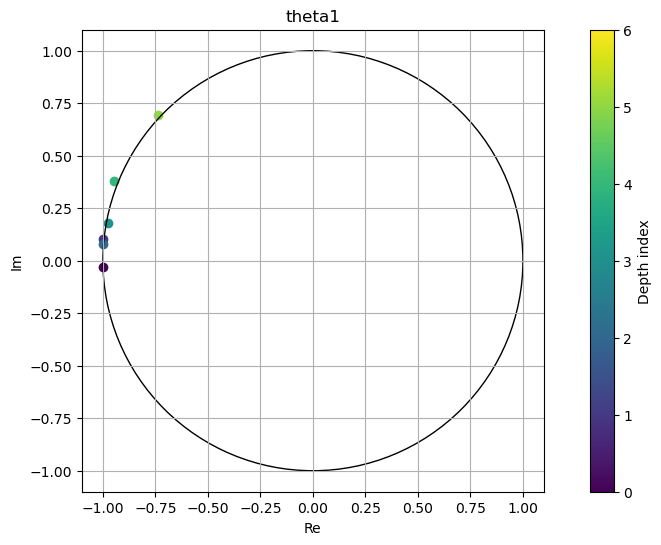

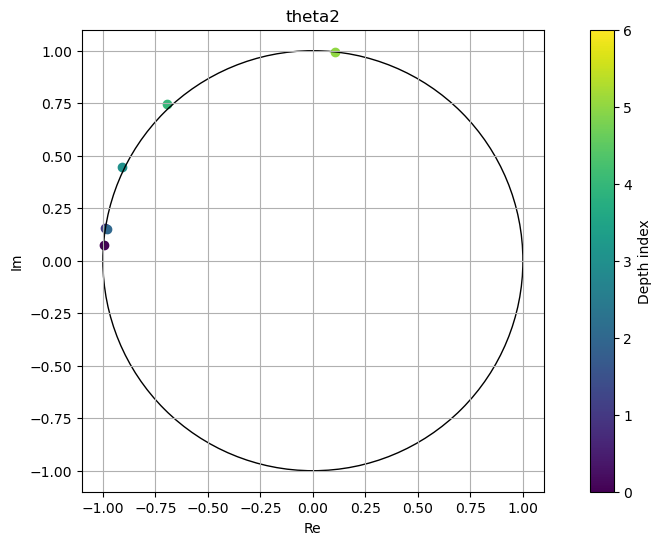

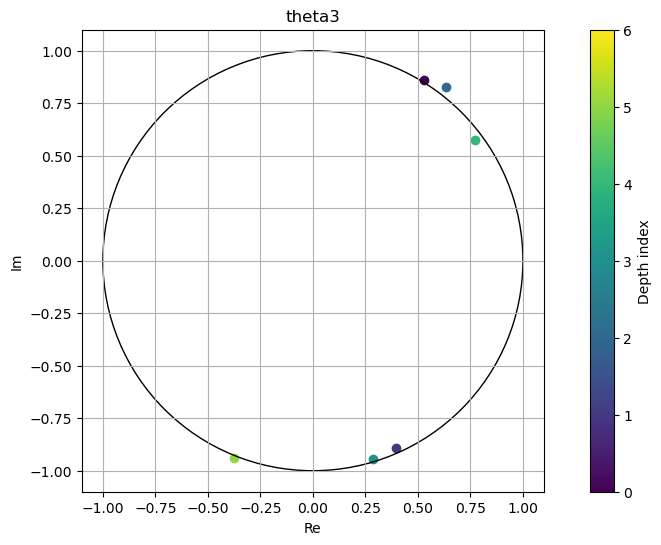

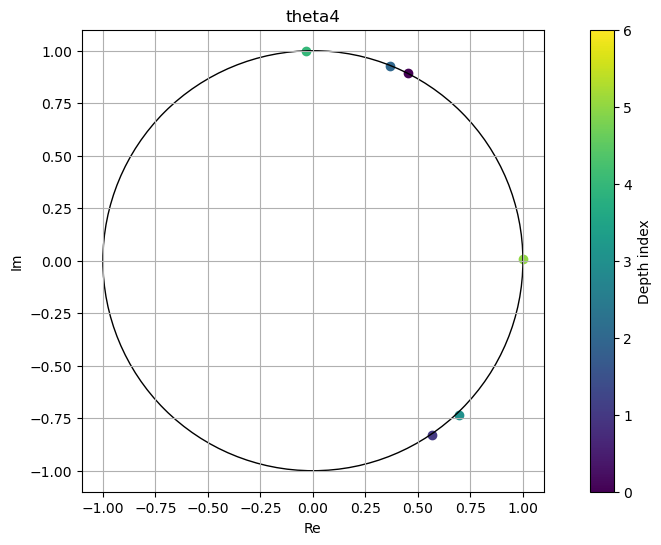

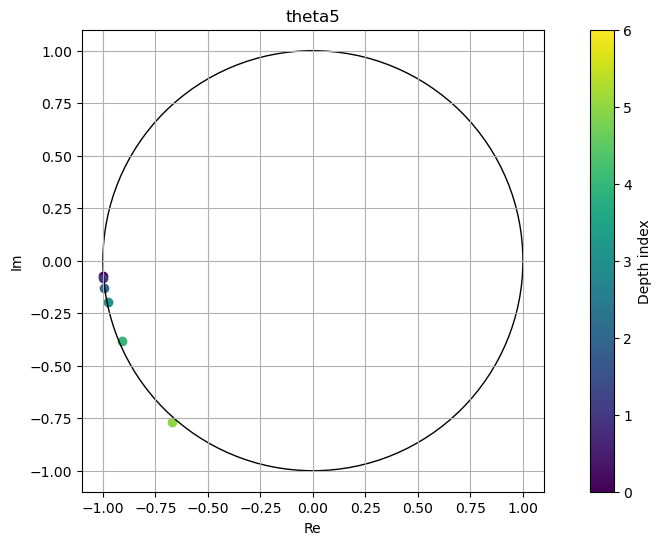

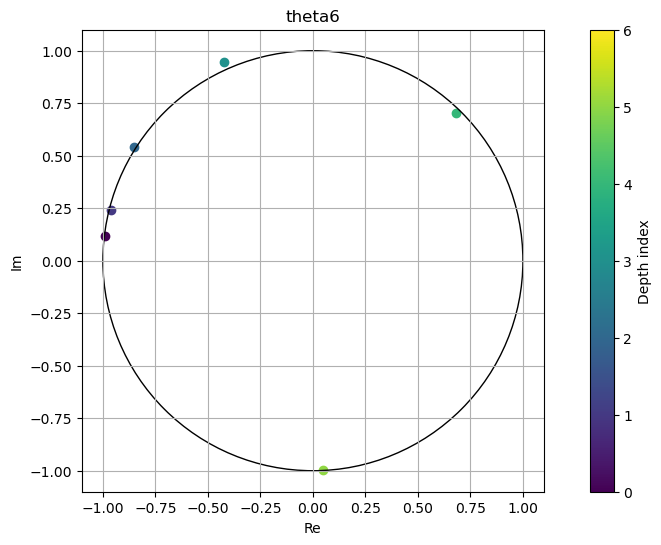

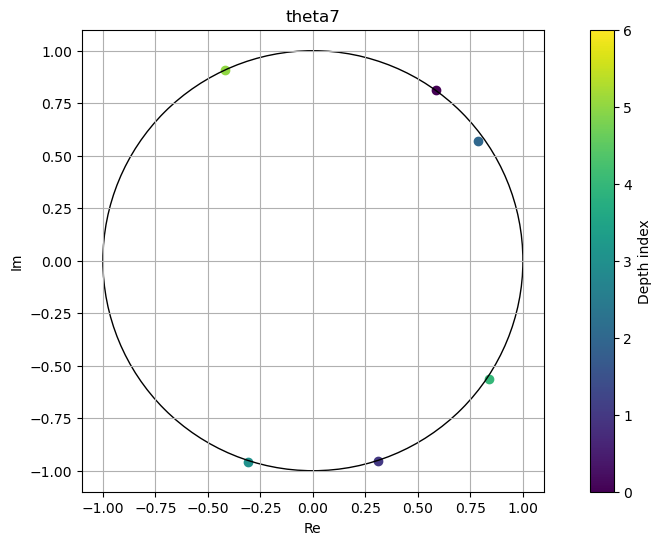

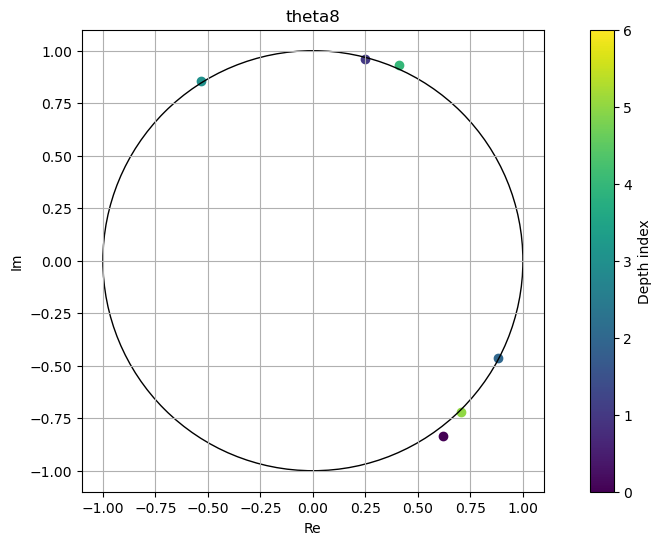

In [602]:
estimator2.plot_all_signals()

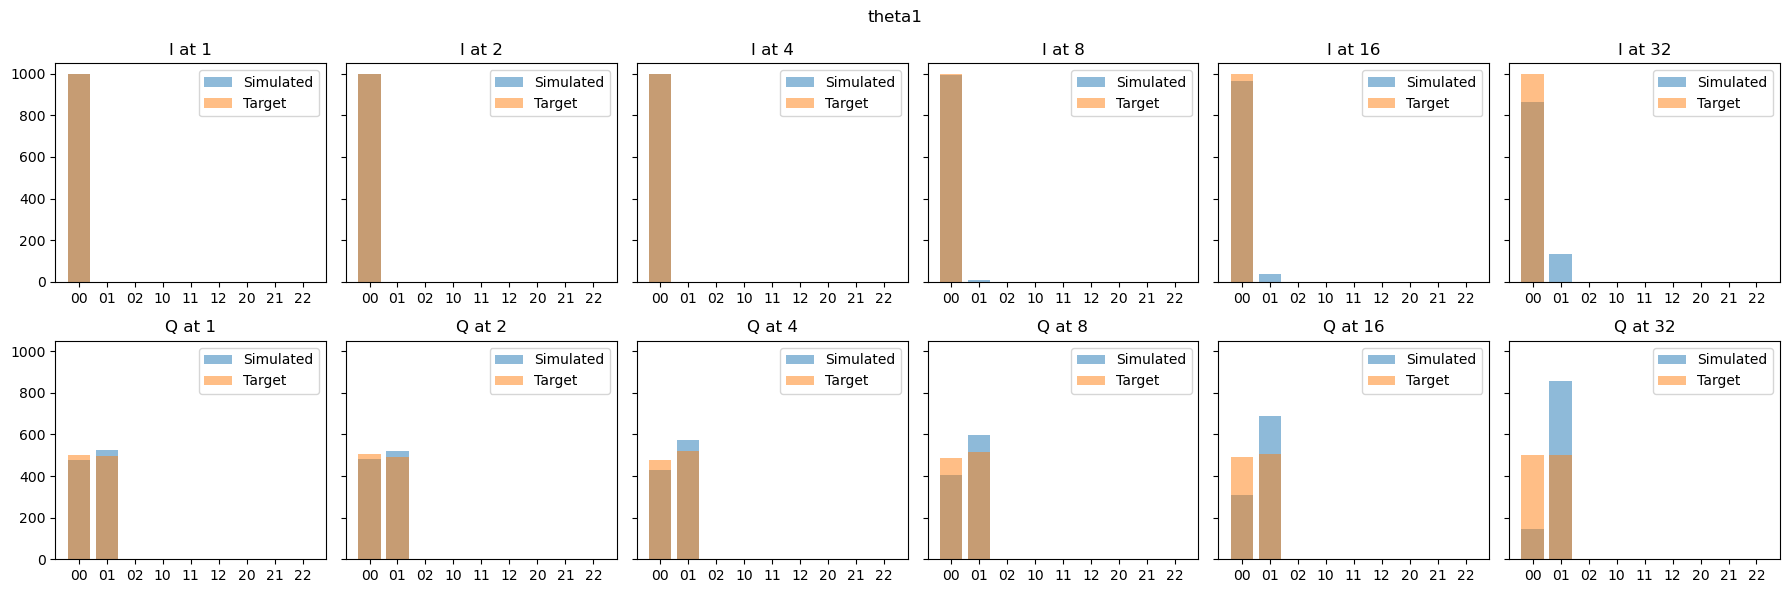

<Figure size 640x480 with 0 Axes>

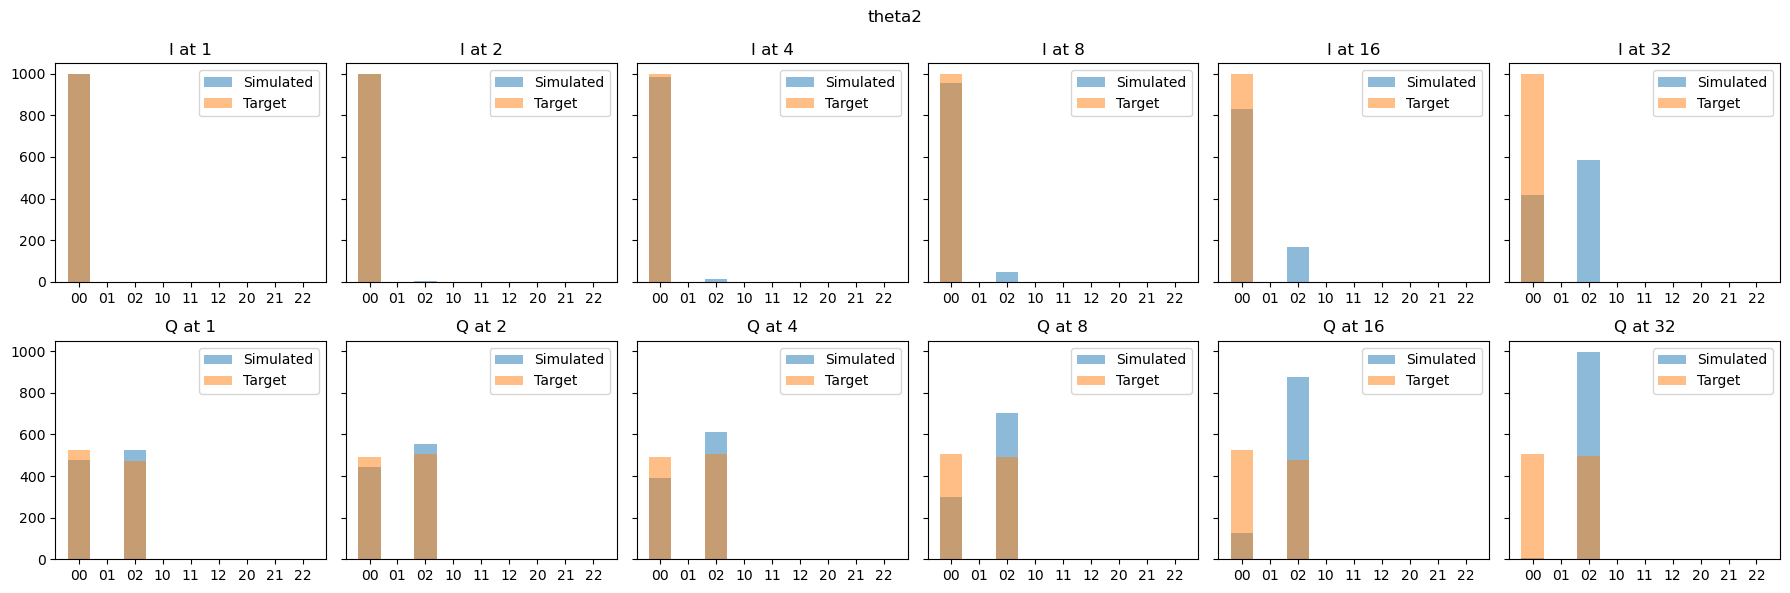

<Figure size 640x480 with 0 Axes>

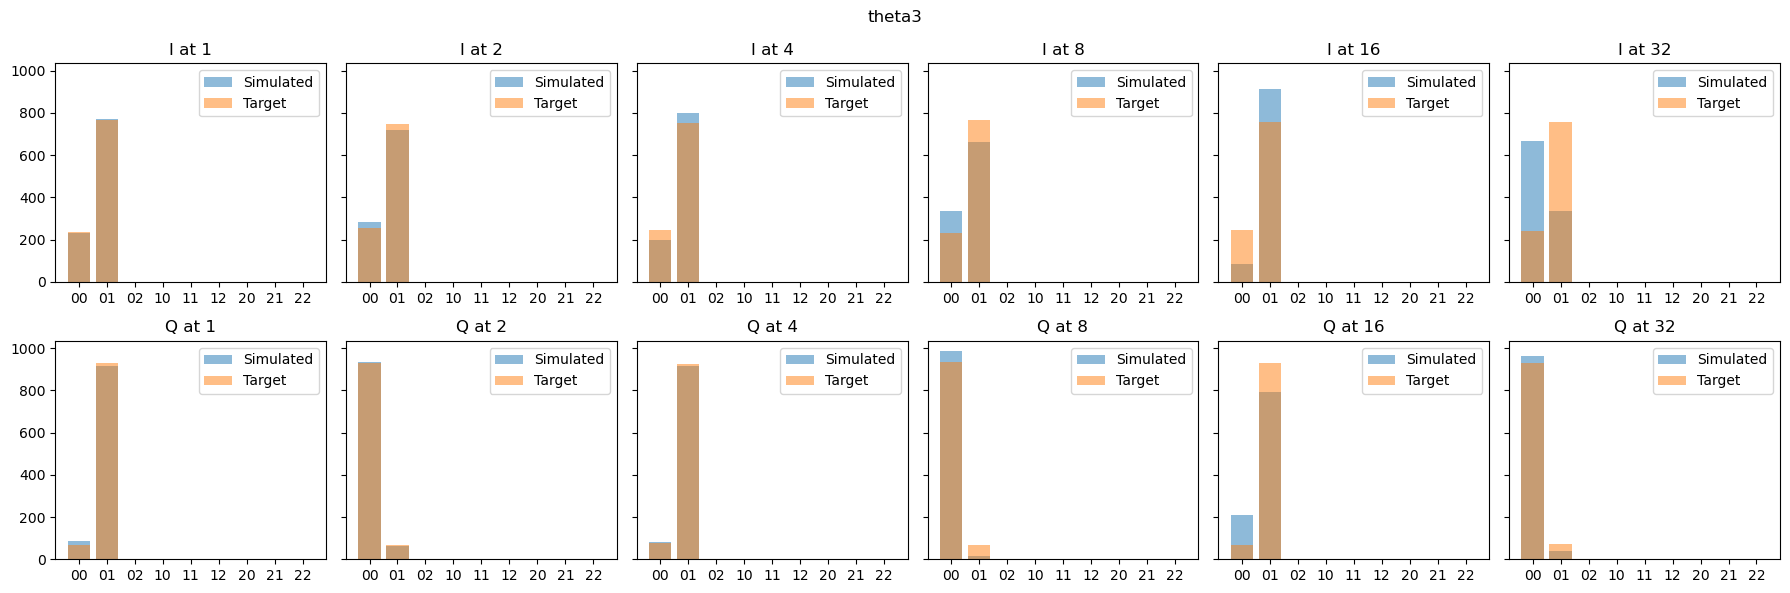

<Figure size 640x480 with 0 Axes>

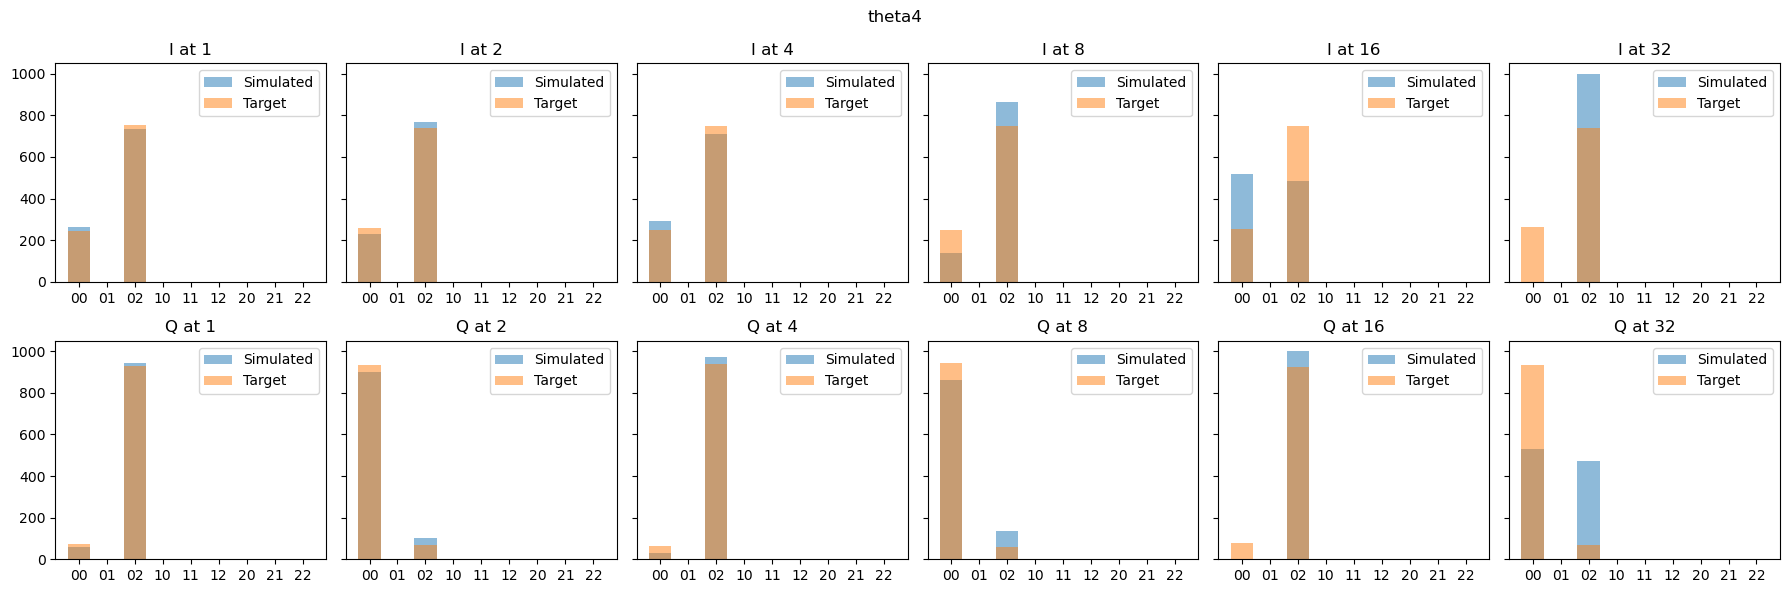

<Figure size 640x480 with 0 Axes>

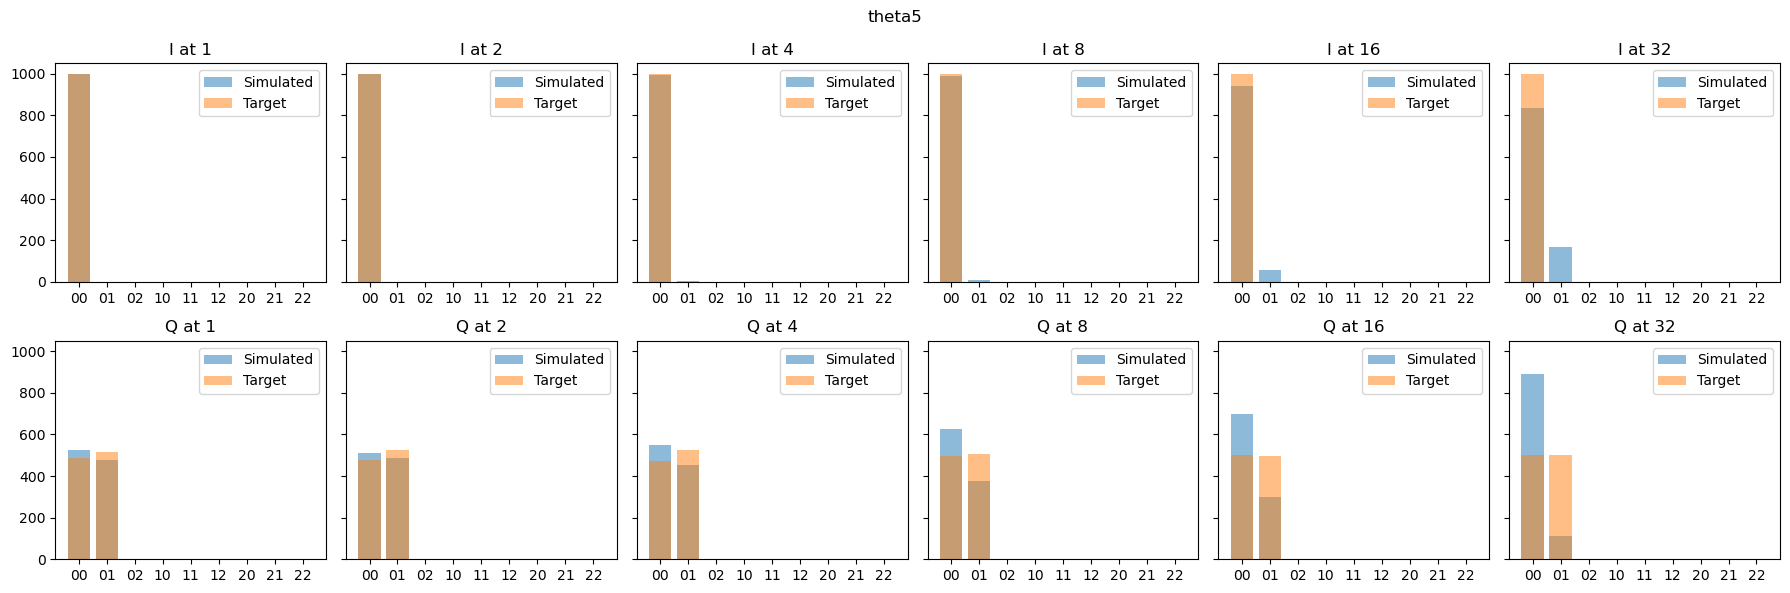

<Figure size 640x480 with 0 Axes>

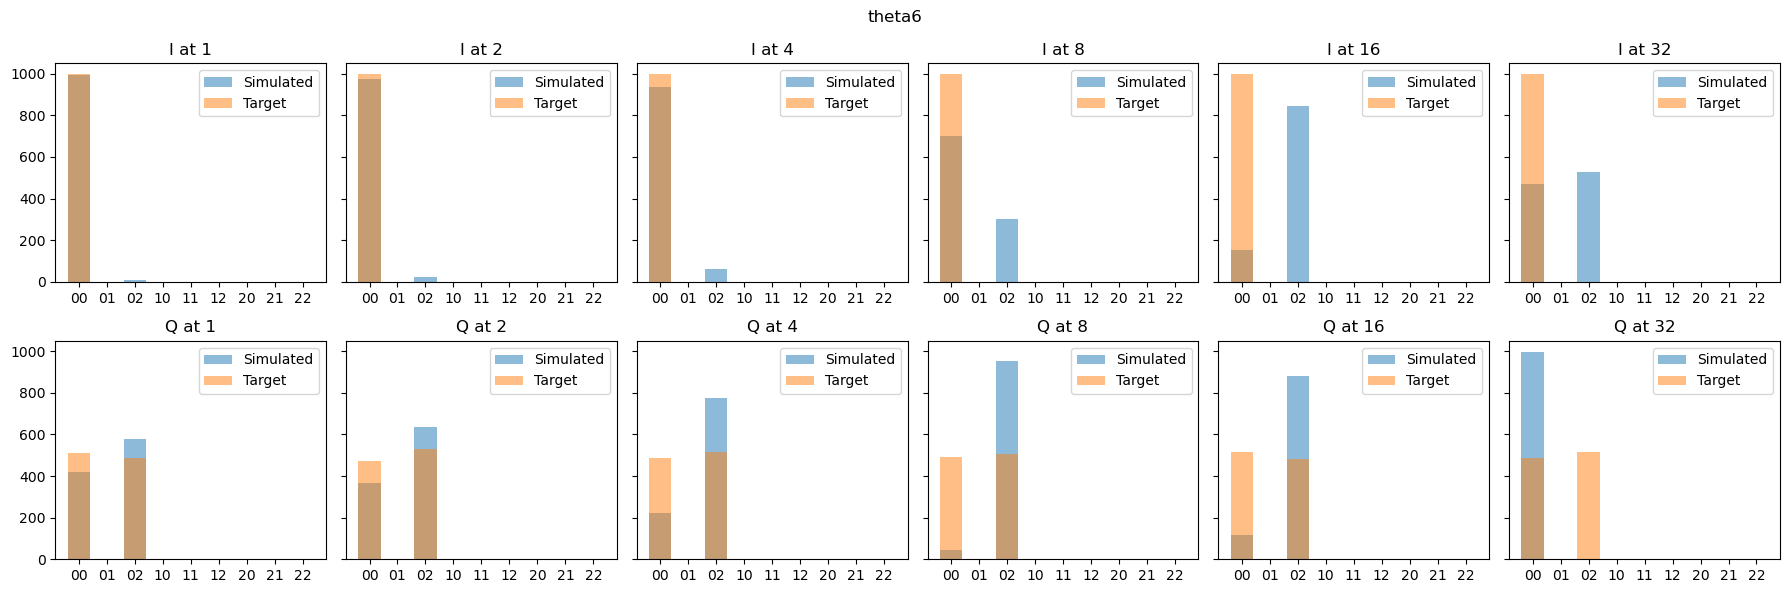

<Figure size 640x480 with 0 Axes>

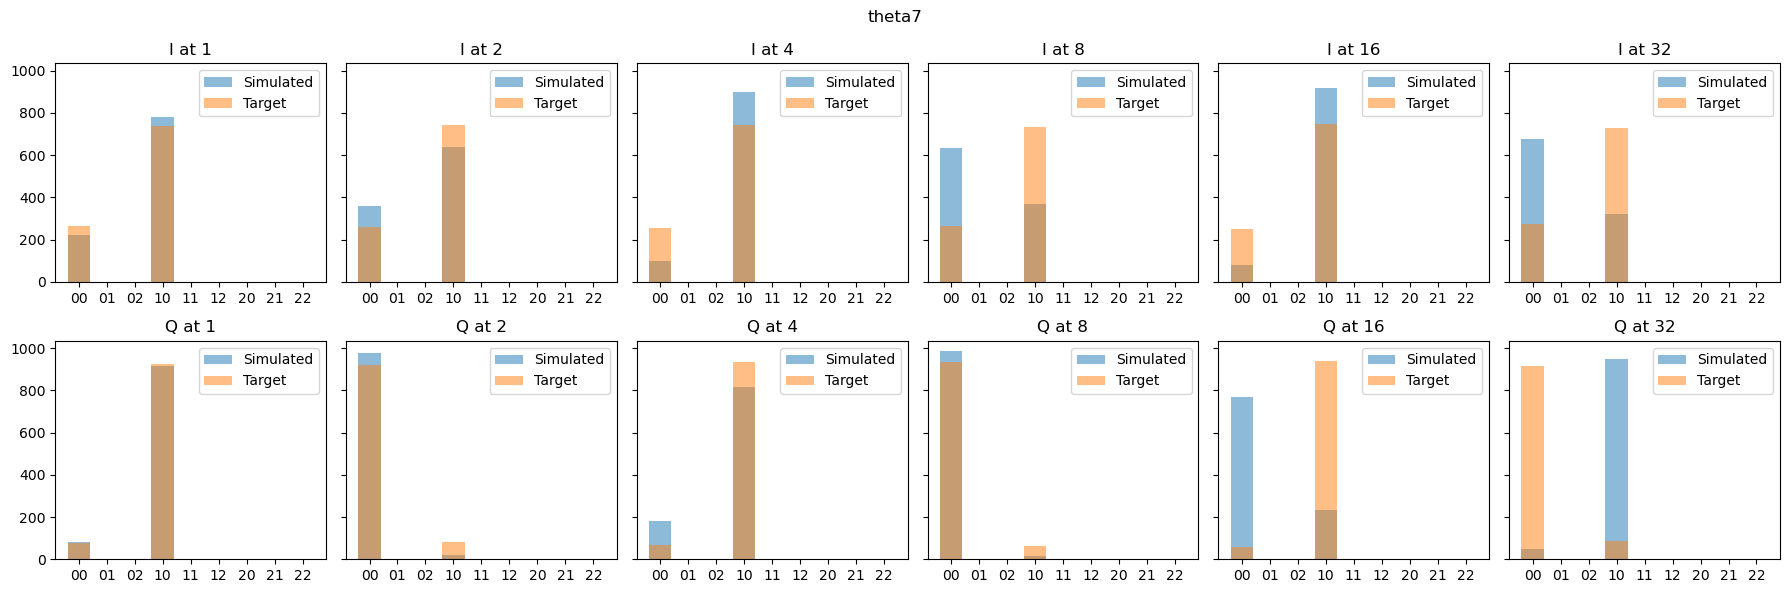

<Figure size 640x480 with 0 Axes>

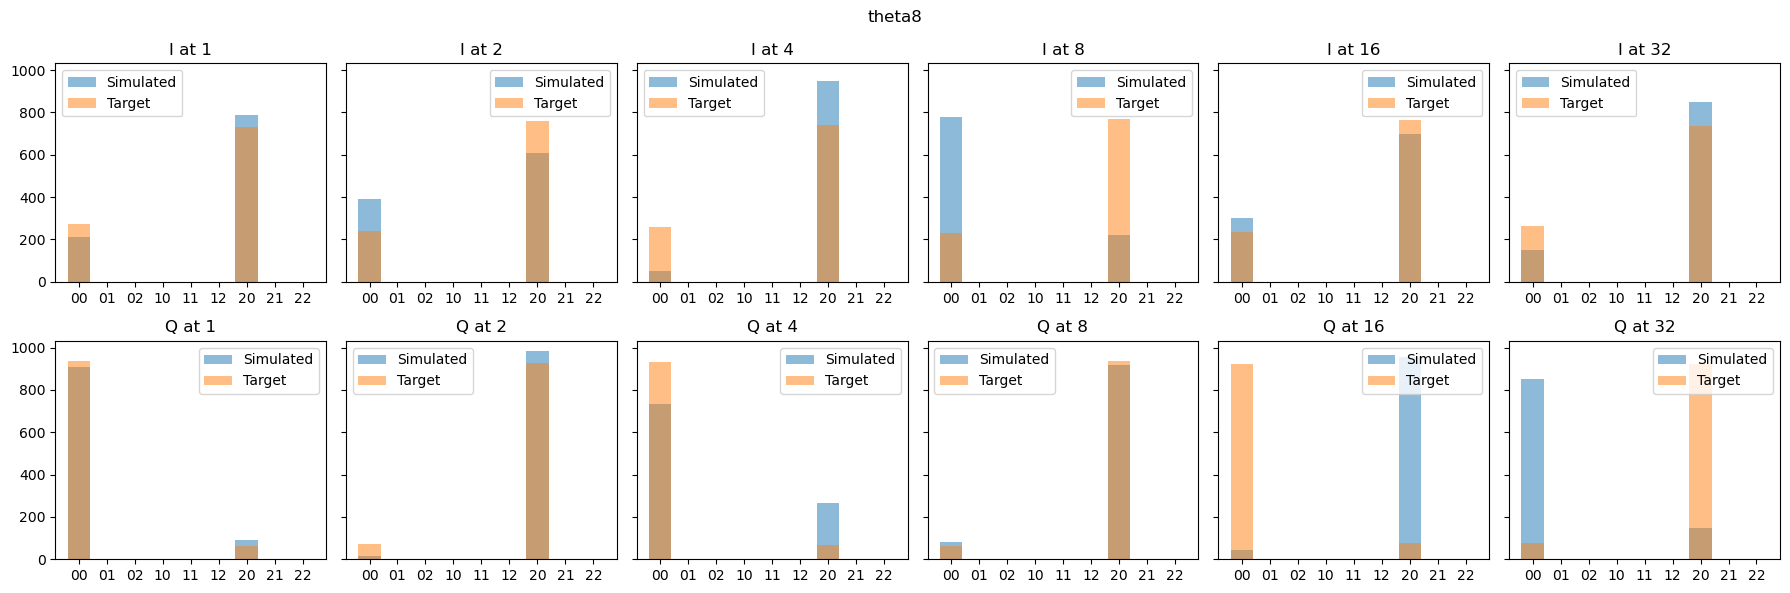

<Figure size 640x480 with 0 Axes>

In [650]:
estimator2.plot_all_outcomes(ds2_target)